In [1]:
import os
import numpy as np
import torch
from nilearn import plotting
import data
import visualize
from words import make_classifications, Predictions
from data import normalize_fmri_data, unnormalize_fmri_data
from LEM import extract_data_features, predAccuracy
from numpy.linalg import norm


In [2]:
class argObj:
    def __init__(self, data_dir, parent_submission_dir, subj):
        self.subj = format(subj, '02')
        self.data_dir = os.path.join(data_dir, 'subj' + self.subj)
        self.parent_submission_dir = parent_submission_dir
        self.subject_submission_dir = os.path.join(self.parent_submission_dir,
                                                   'subj' + self.subj)


In [3]:
platform = 'jupyter_notebook'
device = 'cuda'
device = torch.device('cuda')
# setting up the directories and ARGS
data_dir = 'C:/Users/josem/Documents/schoolWork/MQP/algonauts2023_transformers#2Leader/algonauts_2023_challenge_data/'#../MQP/algonauts_2023_challenge_data/'
parent_submission_dir = '../submission'
subj = 1 # @param ["1", "2", "3", "4", "5", "6", "7", "8"] {type:"raw", allow-input: true}
# args

args = argObj(data_dir, parent_submission_dir, subj)
fmri_dir = os.path.join(args.data_dir, 'training_split', 'training_fmri')
lh_fmri = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))
rh_fmri = np.load(os.path.join(fmri_dir, 'rh_training_fmri.npy'))

words = ['furniture', 'food', 'kitchenware', 'appliance', 'person', 'animal', 'vehicle', 'accessory',
            'electronics', 'sports', 'traffic', 'outdoor', 'home', 'clothing', 'hygiene', 'toy', 'plumbing', 
             'computer', 'fruit', 'vegetable', 'tool']


In [4]:
words = ['furniture', 'food', 'kitchenware', 'appliance', 'person', 'animal', 'vehicle', 'accessory',
            'electronics', 'sports', 'traffic', 'outdoor', 'home', 'clothing', 'hygiene', 'toy', 'plumbing', 
             'computer', 'fruit', 'vegetable', 'tool']

In [4]:
print("________ Process Data ________")

# Normalize Data Before Split
lh_fmri, lh_data_min, lh_data_max = normalize_fmri_data(lh_fmri)
print(lh_fmri)
print("- - - - - - - -")
rh_fmri, rh_data_min, rh_data_max = normalize_fmri_data(rh_fmri)
print(rh_fmri)

print('LH training fMRI data shape:')
print(lh_fmri.shape)
print('(Training stimulus images × LH vertices)')

print('\nRH training fMRI data shape:')
print(rh_fmri.shape)
print('(Training stimulus images × RH vertices)')

train_img_dir = os.path.join(args.data_dir, 'training_split', 'training_images')
test_img_dir = os.path.join(args.data_dir, 'test_split', 'test_images')
train_img_list = os.listdir(train_img_dir)
train_img_list.sort()
train_img_list = train_img_list[:1000]
test_img_list = os.listdir(test_img_dir)
test_img_list.sort()

print('\nTraining images: ' + str(len(train_img_list)))
print('\nTest images: ' + str(len(test_img_list)))
train_img_file = train_img_list[0]
print('\nTraining image file name: ' + train_img_file)
print('\n73k NSD images ID: ' + train_img_file[-9:-4])

________ Process Data ________
-2.515819 2.4762304
[[    0.33133     0.46326     0.37849 ...      0.2802     0.31058     0.48424]
 [    0.64868     0.44725     0.68909 ...     0.73208     0.73593     0.78369]
 [    0.44218     0.31722     0.84834 ...     0.43348     0.40331     0.46675]
 ...
 [    0.62769     0.55193     0.67142 ...     0.69863     0.72638     0.71742]
 [    0.44796     0.47105     0.62229 ...     0.55655     0.54892     0.62596]
 [    0.22312     0.42925     0.37006 ...     0.63066     0.60185     0.55653]]
- - - - - - - -
-2.5166664 2.4293716
[[    0.87571     0.39814     0.50907 ...     0.42413     0.38705     0.37228]
 [    0.61258     0.70873     0.49787 ...     0.80909     0.83579     0.84486]
 [    0.75225     0.48751     0.24973 ...     0.58831     0.62981     0.64943]
 ...
 [    0.50022     0.60346     0.57408 ...     0.57377     0.50956     0.43088]
 [    0.84737     0.50435      0.4118 ...     0.49836      0.5347     0.54115]
 [     0.4397     0.60309     0.

In [5]:
print("________ Split Data ________")

idxs_train, idxs_val, idxs_test = splitdata(train_img_list, test_img_list, train_img_dir)
lh_fmri_train = lh_fmri[idxs_train]
rh_fmri_train = rh_fmri[idxs_train]
lh_fmri_val = lh_fmri[idxs_val]
rh_fmri_val = rh_fmri[idxs_val]
lh_fmri_test = lh_fmri[idxs_test]
rh_fmri_test = rh_fmri[idxs_test]

________ Split Data ________
Training stimulus images: 900

Validation stimulus images: 100

Test stimulus images: 159


In [6]:
print("________ Make Lists ________")

train_images = makeList(train_img_dir, train_img_list, idxs_train)
val_images = makeList(train_img_dir, train_img_list, idxs_val)
test_images = makeList(test_img_dir, test_img_list, idxs_test)
torch.cuda.empty_cache()

________ Make Lists ________


In [ ]:
print("________ Make Classifications ________")
lh_classifications = make_classifications(train_images, idxs_train, device)
rh_classifications = lh_classifications
lh_classifications_val = make_classifications(val_images, idxs_val, device)
rh_classifications_val = lh_classifications_val
lh_classifications_test = make_classifications(test_images, idxs_test, device)
rh_classifications_test = lh_classifications_test

torch.cuda.empty_cache()

In [ ]:
print("________ Extract Image Features ________")

train_imgs_dataloader, val_imgs_dataloader, test_imgs_dataloader = (
    transformData(train_img_dir, test_img_dir, idxs_train, idxs_val, idxs_test, 64))

features_train, trainImagePaths, features_val, validImagePaths, features_test, testImagePaths = (
    extract_data_features(train_imgs_dataloader, val_imgs_dataloader, test_imgs_dataloader, 64))

________ Extract Image Features ________


Extracting Features: 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]


Training images features:
(8857, 64)
(Training stimulus images × PCA features)

Validation images features:
(984, 64)
(Validation stimulus images × PCA features)

Test images features:
(159, 64)
(Test stimulus images × PCA features)


In [ ]:
print("________ Organize Input________")

dftrainL, dftrainFL = organize_input(lh_classifications, features_train, trainImagePaths, lh_fmri_train)
dftrainR, dftrainFR = organize_input(rh_classifications, features_train, trainImagePaths, rh_fmri_train)

dfvalL, dfvalFL = organize_input(lh_classifications_val, features_val, validImagePaths, lh_fmri_val)
dfvalR, dfvalFR = organize_input(rh_classifications_val, features_val, validImagePaths, rh_fmri_val)

dftestL, dftestFL = organize_input(lh_classifications_test, features_test, testImagePaths, lh_fmri_test)
dftestR, dftestFR = organize_input(rh_classifications_test, features_test, testImagePaths, rh_fmri_test)

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import torch
from torch.utils.data import DataLoader, TensorDataset, Dataset
from ultralytics import YOLO
from gradCam.models import roiVGGYolo
from torchvision import transforms

In [ ]:
yoloTsfms = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor()
])


lModel = roiVGGYolo(dftrainFL.shape[0], yoloTsfms).to("cuda:1")
rModel = roiVGGYolo(dftrainFL.shape[0], yoloTsfms).to("cuda:1")

In [10]:
print("________ Predictions Validation ________")
lh_fmri_val_pred = Predictions(dfvalL, dfvalFL,lModel)
rh_fmri_val_pred = Predictions(dfvalR, dfvalFR)

________ Predictions Validation ________
PREDICTIONS
[[    0.58582     0.46208     0.55602 ...     0.44695      0.4853     0.39012]
 [    0.53031     0.41261     0.20612 ...     0.38756     0.31653     0.46265]
 [     0.5813     0.64572     0.65082 ...     0.50731     0.49914     0.45125]
 ...
 [    0.20881       0.295     0.47646 ...     0.36801     0.29388     0.39038]
 [     0.5874     0.46502     0.63557 ...     0.48936     0.48192     0.58774]
 [    0.60275     0.54152     0.52044 ...     0.54478     0.66644     0.52105]] 
 _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
 [[    0.54284     0.55622     0.62617 ...     0.59834     0.59137     0.55541]
 [    0.49799     0.46861     0.45105 ...     0.48964     0.49052     0.49499]
 [    0.55867     0.56202     0.54528 ...     0.51152     0.52237     0.49661]
 ...
 [    0.50769     0.46251     0.42856 ...     0.41436     0.42375     0.45352]
 [     0.5192     0.49442     0.47075 ...     0.50641     0.50684     0.51204]
 [    0.57642     0.51573     0.39

In [11]:
print("________ Predictions Test________")
lh_fmri_test_pred = Predictions(dftrainL, dftrainFL, dftestL, dftestFL)
rh_fmri_test_pred = Predictions(dftrainR, dftrainFR, dftestR, dftestFR)

________ Predictions Test________
PREDICTIONS
[[    0.33133     0.46326     0.37849 ...      0.2802     0.31058     0.48424]
 [    0.64868     0.44725     0.68909 ...     0.73208     0.73593     0.78369]
 [    0.44218     0.31722     0.84834 ...     0.43348     0.40331     0.46675]
 ...
 [    0.31642     0.28488     0.37538 ...     0.38776     0.34312     0.41256]
 [    0.41328     0.53082     0.62215 ...      0.7056     0.70056     0.66135]
 [    0.59368     0.51872      0.7144 ...     0.37513     0.32682      0.2032]] 
 _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
 [[    0.53204     0.46033      0.3801 ...      0.5252     0.51887     0.55865]
 [    0.48874      0.4872     0.56344 ...     0.60145     0.58863     0.56765]
 [    0.48249     0.46559     0.50357 ...     0.49641      0.4874     0.49456]
 ...
 [    0.48849     0.48393      0.6753 ...     0.58147     0.57236     0.54808]
 [    0.50198     0.49788      0.3964 ...     0.40099     0.40805     0.44135]
 [    0.45664      0.4671     0.54047 ...

In [10]:
class_mapping = {
    'chair': 'furniture',
    'bowl': 'kitchenware',
    'dining table': 'furniture',
    'person': 'person',
    'bird': 'animal',
    'knife': 'kitchenware',
    'sink': 'appliance',
    'horse': 'animal',
    'cake': 'food',
    'giraffe': 'animal',
    'car': 'vehicle',
    'umbrella': 'accessory',
    'refrigerator': 'appliance',
    'cow': 'animal',
    'dog': 'animal',
    'tv': 'electronics',
    'surfboard': 'sports',
    'cat': 'animal',
    'stop sign': 'traffic',
    'train': 'vehicle',
    'zebra': 'animal',
    'carrot': 'vegetable',
    'bicycle': 'vehicle',
    'sports ball': 'sports',
    'sheep': 'animal',
    'motorcycle': 'vehicle',
    'bottle': 'kitchenware',
    'sandwich': 'food',
    'clock': 'home',
    'bear': 'animal',
    'truck': 'vehicle',
    'traffic light': 'traffic',
    'cell phone': 'electronics',
    'oven': 'appliance',
    'cup': 'kitchenware',
    'couch': 'furniture',
    'airplane': 'vehicle',
    'boat': 'vehicle',
    'bus': 'vehicle',
    'broccoli': 'vegetable',
    'tennis racket': 'sports',
    'elephant': 'animal',
    'parking meter': 'traffic',
    'tie': 'clothing',
    'bed': 'furniture',
    'toaster': 'appliance',
    'banana': 'fruit',
    'toothbrush': 'hygiene',
    'kite': 'toy',
    'skateboard': 'sports',
    'potted plant': 'home',
    'bench': 'outdoor',
    'donut': 'food',
    'spoon': 'kitchenware',
    'toilet': 'plumbing',
    'baseball bat': 'sports',
    'pizza': 'food',
    'scissors': 'tool',
    'fire hydrant': 'outdoor',
    'teddy bear': 'toy',
    'remote': 'electronics',
    'apple': 'fruit',
    'suitcase': 'luggage',
    'vase': 'home',
    'skis': 'sports',
    'hot dog': 'food',
    'frisbee': 'toy',
    'backpack': 'luggage',
    'microwave': 'appliance',
    'wine glass': 'kitchenware',
    'snowboard': 'sports',
    'baseball glove': 'sports',
    'book': 'toy',
    'orange': 'fruit',
    'fork': 'kitchenware',
    'laptop': 'electronics',
    'handbag': 'accessory',
    'keyboard': 'computer',
    'mouse': 'computer'
}

In [14]:
for i in sorted(set(class_mapping.keys())):
    print(f"{i}, ", end="")

airplane, apple, backpack, banana, baseball bat, baseball glove, bear, bed, bench, bicycle, bird, boat, book, bottle, bowl, broccoli, bus, cake, car, carrot, cat, cell phone, chair, clock, couch, cow, cup, dining table, dog, donut, elephant, fire hydrant, fork, frisbee, giraffe, handbag, horse, hot dog, keyboard, kite, knife, laptop, microwave, motorcycle, mouse, orange, oven, parking meter, person, pizza, potted plant, refrigerator, remote, sandwich, scissors, sheep, sink, skateboard, skis, snowboard, spoon, sports ball, stop sign, suitcase, surfboard, teddy bear, tennis racket, tie, toaster, toilet, toothbrush, traffic light, train, truck, tv, umbrella, vase, wine glass, zebra, 

In [12]:
print("________ Unnormalize Data ________")

lh_fmri_val_pred = unnormalize_fmri_data(lh_fmri_val_pred, lh_data_min, lh_data_max)
rh_fmri_val_pred = unnormalize_fmri_data(rh_fmri_val_pred, rh_data_min, rh_data_max)
lh_fmri_test_pred = unnormalize_fmri_data(lh_fmri_test_pred, lh_data_min, lh_data_max)
rh_fmri_test_pred = unnormalize_fmri_data(rh_fmri_test_pred, rh_data_min, rh_data_max)


________ Unnormalize Data ________


In [8]:
allLhIndices = np.load("./VisRun/combinedLossIndices.npy")
allRhIndices = np.load("./VisRun/validIdxsRh.npy")


In [9]:
allLhIndices = allLhIndices.astype(int)
allRhIndices = allRhIndices.astype(int)

In [12]:
# allLhIndices

In [4]:
lh_classifications_val = np.load("./VisRun/lh_class_val.npy")
# rh_classifications_val = np.load("./VisRun/lhClassificationPred.npy")[allRhIndices]

In [9]:
lh_classifications_val.shape

(975, 2)

In [5]:
fmri_dir = "C:/Users/josem/Documents/schoolWork/MQP/algonauts2023_transformers#2Leader/algonauts_2023_challenge_data/subj01/training_split/training_fmri"

In [6]:
from sklearn.model_selection import train_test_split, KFold
# k_folds = 5
# skf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

#Get the validation indexes used for the fold that resulted in the best params
_, validationIdxs = train_test_split(range(9841), train_size=0.9, random_state = 42)
# list(skf.split(np.arange(9841)))[4][1]

In [7]:
validationIdxs = np.array(validationIdxs)

In [6]:
idxs_val = np.load("./VisRun/valIdxs.npy")

In [7]:
print("________ Re-Load Data ________")
lh_fmri = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))
rh_fmri = np.load(os.path.join(fmri_dir, 'rh_training_fmri.npy'))

lh_fmri_val = lh_fmri[idxs_val]
rh_fmri_val = rh_fmri[idxs_val]

lh_fmri_val_pred = np.load("./VisRun/lh_fmri_val_pred.npy")


# print("________ Re-Load Data ________")
# lh_fmri = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))
# rh_fmri = np.load(os.path.join(fmri_dir, 'rh_training_fmri.npy'))

# lh_fmri_val = lh_fmri[validationIdxs[allLhIndices]]
# rh_fmri_val = rh_fmri[:10]

# rh_fmri_val_pred = np.load("./VisRun/rhFMRIPred.npy")[:10]

# # lh_fmri_test = lh_fmri[idxs_train]
# # rh_fmri_test = rh_fmri[idxs_train]
# # print(lh_fmri_test)


________ Re-Load Data ________


In [20]:
lh_fmri_val_pred

array([[  0.0080971,  -0.0070947,  -0.0042465, ...,   -0.012395,     0.01271,   -0.011214],
       [   0.056679,   -0.049663,   -0.029726, ...,   -0.086765,    0.088972,   -0.078496],
       [   0.072874,   -0.063852,   -0.038219, ...,    -0.11155,     0.11439,    -0.10092],
       ...,
       [   0.024291,   -0.021284,    -0.01274, ...,   -0.037185,    0.038131,   -0.033641],
       [   0.032388,   -0.028379,   -0.016986, ...,    -0.04958,    0.050841,   -0.044855],
       [    0.16194,    -0.14189,    -0.08493, ...,     -0.2479,     0.25421,    -0.22427]], dtype=float32)

In [16]:

lh_fmri_val_pred = unnormalize_fmri_data(lh_fmri_val_pred, -2.515819, 2.4762304)
rh_fmri_val_pred = unnormalize_fmri_data(rh_fmri_val_pred, -2.5166664, 2.4293716)

In [21]:
print("________ Prediction Accuracy ________")

lh_correlation, rh_correlation = predAccuracy(lh_fmri_val_pred, lh_fmri_val, rh_fmri_val_pred, rh_fmri_val)


________ Prediction Accuracy ________
Start PredAccuracy

predicted
 [[  0.0080971  -0.0070947  -0.0042465 ...   -0.012395     0.01271   -0.011214]
 [   0.056679   -0.049663   -0.029726 ...   -0.086765    0.088972   -0.078496]
 [   0.072874   -0.063852   -0.038219 ...    -0.11155     0.11439    -0.10092]
 ...
 [   0.024291   -0.021284    -0.01274 ...   -0.037185    0.038131   -0.033641]
 [   0.032388   -0.028379   -0.016986 ...    -0.04958    0.050841   -0.044855]
 [    0.16194    -0.14189    -0.08493 ...     -0.2479     0.25421    -0.22427]] 
actual
 [[    0.40555    -0.54157   -0.048368 ...    -0.32394    -0.40157     0.10533]
 [   -0.33966     0.86755    0.051938 ...      1.5427      1.4666     0.47781]
 [   0.082277    -0.67769    0.097822 ...      0.1655     0.34329     0.27515]
 ...
 [   0.062567    0.018855    -0.91235 ...    -0.43393     0.10243     -1.0122]
 [   -0.20217    -0.89535     -1.3222 ...     -0.8487    -0.61484    -0.70999]
 [    0.46031     0.55694    -0.35021 ... 

100%|██████████| 20544/20544 [00:12<00:00, 1662.06it/s]

average lh  0.040162983424795864 average rh  0.8396608939500949


________ Visualize Each Class ________
0 furniture


c:\Users\josem\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\josem\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[    0.12889     0.25632     0.58321 ...     0.27636     0.27927     0.10695]
[  -0.055392     0.27709     0.52509 ...     0.14184     0.10244   -0.024357]


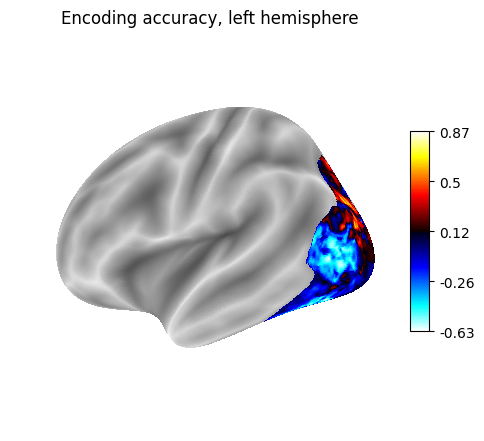

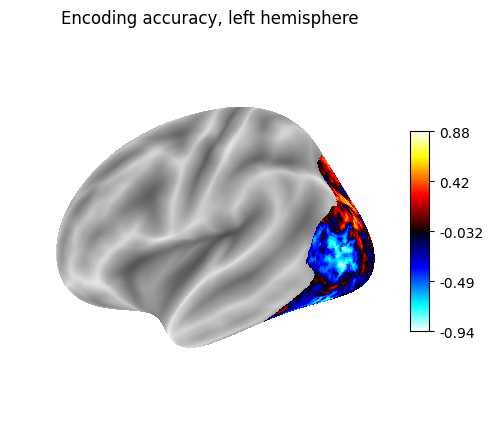

41
Corre  0.3536410225261903
Cosine Similarity: 0.874433612507476
1 food
[   -0.18321    -0.29204     0.22751 ...    -0.16506    -0.22075   -0.022608]
[    -0.1179    -0.38702     0.27839 ...     -0.1295    -0.18037  -0.0079741]


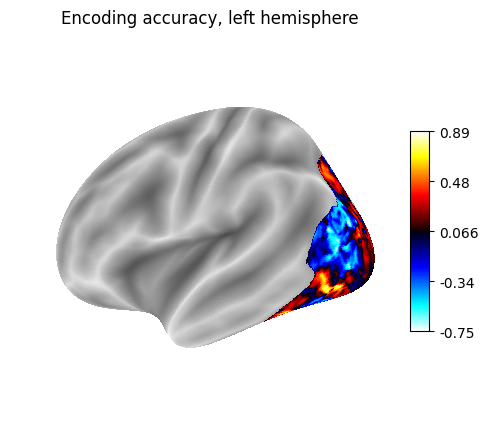

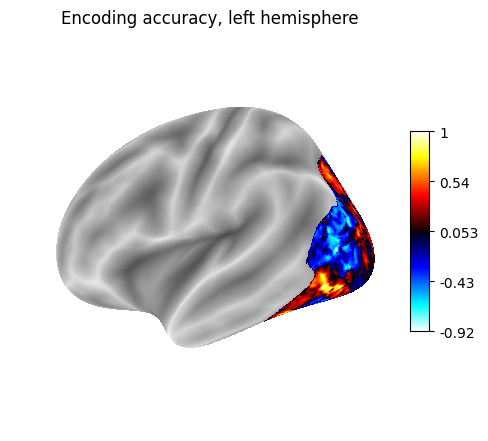

47
Corre  0.35921963152620884
Cosine Similarity: 0.9587415158037152
2 kitchenware
[   -0.10751    -0.22163      0.3374 ...    0.071369     0.01467    0.072951]
[   -0.14482    -0.37211     0.34631 ...    0.041378  -0.0014018    0.086456]


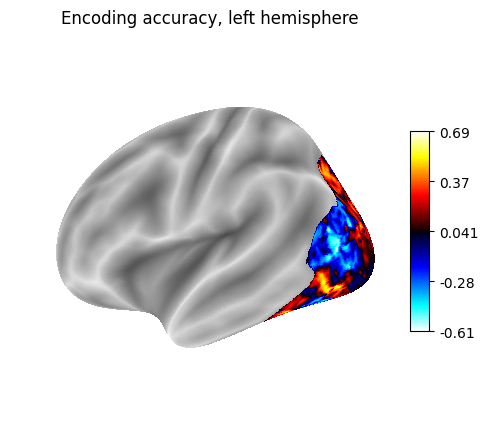

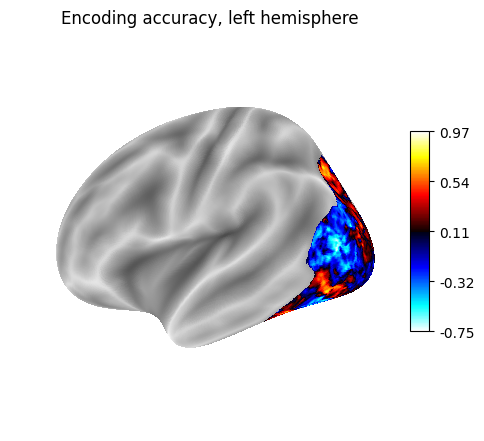

40
Corre  0.2537551945558765
Cosine Similarity: 0.9476880423077633
3 appliance
[   0.097419     0.18813     0.60361 ...     0.35006     0.32258     0.14858]
[    0.21642     0.03461     0.59325 ...     0.36145     0.35984     0.20483]


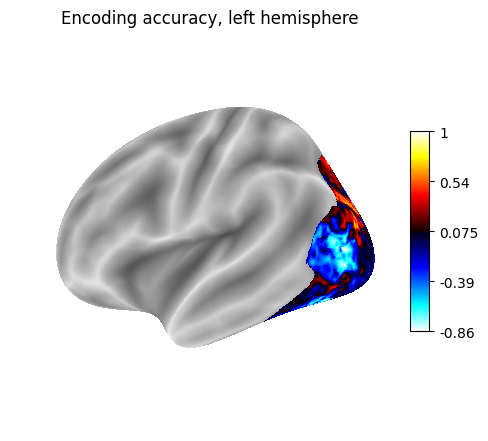

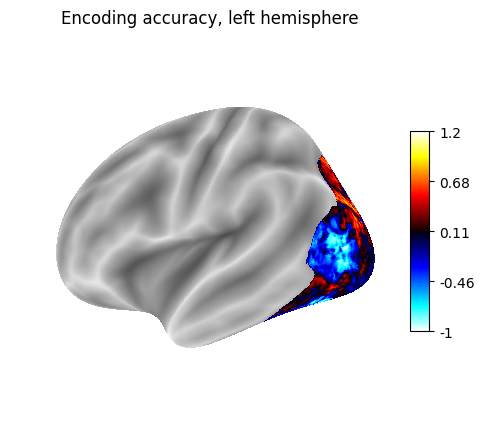

21
Corre  0.47491331534936404
Cosine Similarity: 0.9306946498947015
4 person
[   0.050266    0.050575    -0.18752 ...   -0.072794   -0.051414   -0.041946]
[   0.067068    0.035978    -0.22639 ...   -0.093122   -0.076981   -0.098092]


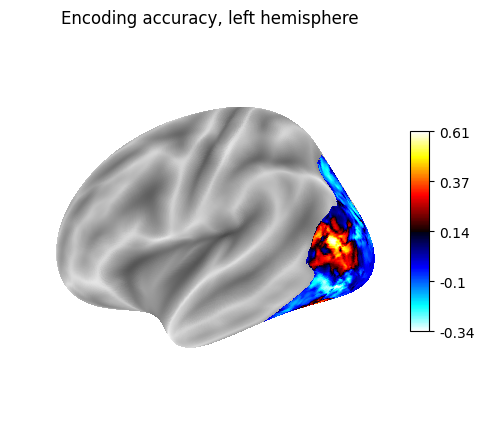

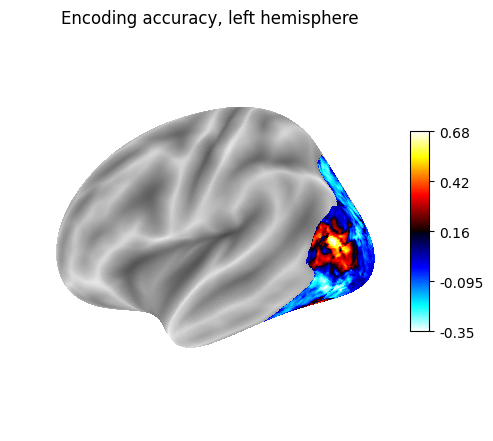

296
Corre  0.12016757766216223
Cosine Similarity: 0.9738473085393121
5 animal
[   -0.10195   -0.056765    -0.19926 ...    -0.17541    -0.15722    -0.10533]
[  -0.058256    -0.11357    -0.13452 ...     -0.2442    -0.21717    -0.14066]


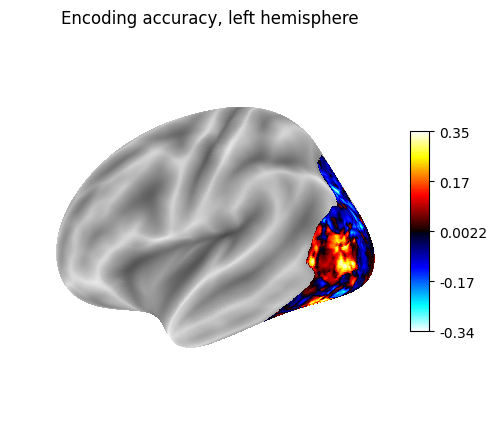

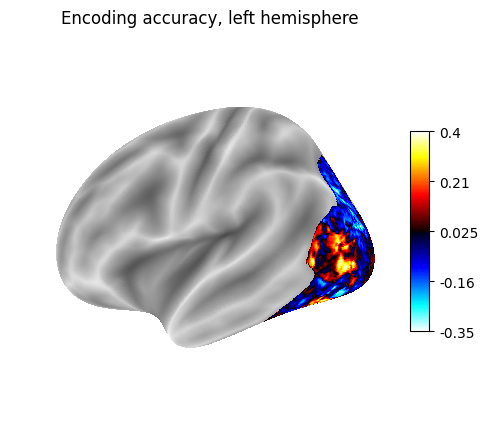

165
Corre  0.08256809358892016
Cosine Similarity: 0.9255186988681448
6 vehicle
[    0.13778     0.25549    0.076801 ...     0.13593     0.14001    0.085664]
[    0.10562     0.22064     0.13278 ...     0.25927     0.23811    0.087032]


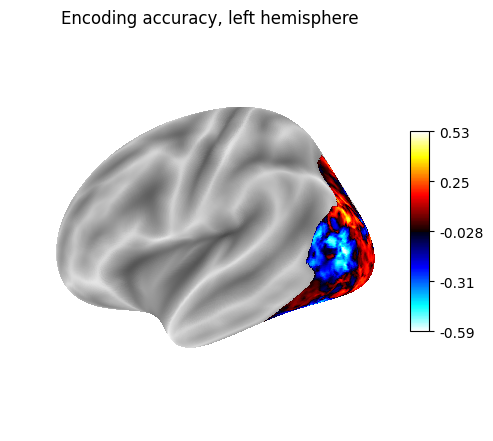

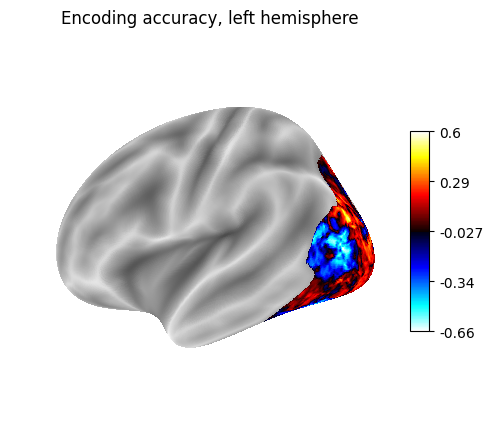

119
Corre  0.19251986352210254
Cosine Similarity: 0.9640090468835995
7 accessory
[   0.007843    0.047666    0.040064 ...    0.067377    0.075264    0.043497]
[    0.14534    -0.38567     0.25622 ...    -0.24589    -0.20711    -0.23801]


KeyboardInterrupt: 

In [8]:
print("________ Visualize Each Class ________")

length = len(words)
for clss in range(length):
    print(clss, words[clss])
    avg_lh_pred = []
    avg_lh_real = []
    avg_rh_pred = []
    avg_rh_real = []
    for i in range(len(lh_classifications_val)):

        if lh_classifications_val[i][1] == clss:
            avg_lh_pred.append(lh_fmri_val_pred[i])
            avg_lh_real.append(lh_fmri_val[i])

        # if rh_classifications_val[i][1] == clss:
        #     avg_rh_pred.append(rh_fmri_val_pred[i])
        #     avg_rh_real.append(lh_fmri_val[i])

    if(len(avg_lh_pred)  == 0):
        pass
    else:
        lh = np.mean(avg_lh_pred, axis=0)
        rh = np.mean(avg_rh_pred, axis=0)

        #print("MEAN PRED LH:\n", lh)
        #print("MEAN PRED RH:\n", rh)
        visualize.plot_predictions(args, lh, rh)
        lh2 = np.mean(avg_lh_real, axis=0)
        rh2 = np.mean(avg_rh_real, axis=0)

        #print("MEAN REAL LH:\n", lh2)
        #print("MEAN REAL RH:\n", rh2)
        visualize.plot_predictions(args, lh2, rh2)
        plotting.show()

        corr = np.corrcoef(avg_lh_pred, avg_lh_real)
        print(len(avg_lh_pred))
        print("Corre ", np.mean(corr))
        cosine = np.dot(lh,lh2)/(norm(lh)*norm(lh2))
        print("Cosine Similarity:", cosine)
        torch.cuda.empty_cache()

print("________ END ________")

In [16]:
print("________ Visualize Each Class ________")

length = len(words)
for clss in range(length):
    print(clss, words[clss])
    avg_lh_pred = []
    avg_lh_real = []
    avg_rh_pred = []
    avg_rh_real = []
    for i in range(len(lh_classifications_test)):

        if lh_classifications_test[i][1] == clss:
            avg_lh_pred.append(lh_fmri_test_pred[i])
            avg_lh_real.append(lh_fmri_test[i])

        if rh_classifications[i][1] == clss:
            avg_rh_pred.append(rh_fmri_test_pred[i])
            avg_rh_real.append(lh_fmri_test[i])

    if(len(avg_lh_pred)  == 0):
        pass
    else:
        lh = np.mean(avg_lh_pred, axis=0)
        rh = np.mean(avg_rh_pred, axis=0)

        #print("MEAN PRED LH:\n", lh)
        #print("MEAN PRED RH:\n", rh)
        visualize.plot_predictions(args, lh, rh)
        lh2 = np.mean(avg_lh_real, axis=0)
        rh2 = np.mean(avg_rh_real, axis=0)

        #print("MEAN REAL LH:\n", lh2)
        #print("MEAN REAL RH:\n", rh2)
        visualize.plot_predictions(args, lh2, rh2)
        plotting.show()

        corr = np.corrcoef(avg_lh_pred, avg_lh_real)
        print(len(avg_lh_pred))
        print("Corre ", np.mean(corr))
        cosine = np.dot(lh,lh2)/(norm(lh)*norm(lh2))
        print("Cosine Similarity:", cosine)
        torch.cuda.empty_cache()

print("________ END ________")

________ Visualize Each Class ________
0 furniture


KeyboardInterrupt: 